# Praca domowa 6: Chess (King-Rook vs King)


In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import urllib.request
import zipfile

from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error

sns.set_theme(style="whitegrid")
np.random.seed(42)


## Dane
Pobranie danych bezposrednio z UCI (archiwum ZIP lub plik .data) i wczytanie do pandas DataFrame z wymaganymi nazwami kolumn.


In [6]:

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

zip_url = "https://cdn.uci-ics-mlr-prod.aws.uci.edu/23/chess%2Bking%2Brook%2Bvs%2Bking.zip"
zip_path = DATA_DIR / "krk.zip"
raw_path = DATA_DIR / "krkopt.data"

if not zip_path.exists() and not raw_path.exists():
    try:
        urllib.request.urlretrieve(zip_url, zip_path)
        print(f"Downloaded: {zip_path}")
    except Exception as e:
        print("Primary download failed, trying fallback...", e)
        fallback_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/krkopt/krkopt.data"
        urllib.request.urlretrieve(fallback_url, raw_path)
        print(f"Downloaded: {raw_path}")

cols = [
    "white_king_file", "white_king_rank",
    "white_rook_file", "white_rook_rank",
    "black_king_file", "black_king_rank",
    "white_depth_of_win",
]

if zip_path.exists():
    with zipfile.ZipFile(zip_path) as zf:
        data_name = [n for n in zf.namelist() if n.endswith(".data")][0]
        with zf.open(data_name) as f:
            df = pd.read_csv(f, header=None, names=cols)
else:
    df = pd.read_csv(raw_path, header=None, names=cols)

df.head()


Downloaded: data/krk.zip


,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,white_depth_of_win
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw


## Preprocessing
Mapowanie plikow szachowych a-h na liczby 1-8, konwersja rangi do int, oraz wyliczenie wymaganych odleglosci.

In [7]:

file_map = {c: i + 1 for i, c in enumerate("abcdefgh")}

depth_labels = [
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
    "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen",
]

depth_map = {"draw": -1}
depth_map.update({name: i for i, name in enumerate(depth_labels)})

df["white_depth_of_win"] = df["white_depth_of_win"].map(depth_map).astype(int)

# New numeric columns

df["wk_file"] = df["white_king_file"].map(file_map).astype(int)
df["wr_file"] = df["white_rook_file"].map(file_map).astype(int)
df["bk_file"] = df["black_king_file"].map(file_map).astype(int)

df["wk_rank"] = df["white_king_rank"].astype(int)
df["wr_rank"] = df["white_rook_rank"].astype(int)
df["bk_rank"] = df["black_king_rank"].astype(int)

# Distances WK-BK (P2)
df["dist_euclid"] = np.sqrt((df["wk_file"] - df["bk_file"])**2 + (df["wk_rank"] - df["bk_rank"])**2)
df["dist_manhattan"] = (df["wk_file"] - df["bk_file"]).abs() + (df["wk_rank"] - df["bk_rank"]).abs()
df["dist_chebyshev"] = np.maximum((df["wk_file"] - df["bk_file"]).abs(), (df["wk_rank"] - df["bk_rank"]).abs())

# Distance of BK to nearest edge (P3)
df["edge_dist"] = pd.concat(
    [
        df["bk_file"] - 1,
        8 - df["bk_file"],
        df["bk_rank"] - 1,
        8 - df["bk_rank"],
    ],
    axis=1,
).min(axis=1)

df[[
    "white_depth_of_win", "wk_file", "wk_rank", "wr_file", "wr_rank",
    "bk_file", "bk_rank", "dist_euclid", "dist_manhattan", "dist_chebyshev", "edge_dist"
]].head()


,white_depth_of_win,wk_file,wk_rank,wr_file,wr_rank,bk_file,bk_rank,dist_euclid,dist_manhattan,dist_chebyshev,edge_dist
0,-1,1,1,2,3,3,2,2.236068,3,2,1
1,-1,1,1,3,1,3,2,2.236068,3,2,1
2,-1,1,1,3,1,4,1,3.000000,3,3,0
3,-1,1,1,3,1,4,2,3.162278,4,3,1
4,-1,1,1,3,2,3,1,2.000000,2,2,0


## P1 – Pozycja czarnego krola przy macie i remisie
Porownanie rozkladu pozycji czarnego krola (BK) na planszy dla przypadkow mate (depth=0) i draw (depth=-1).

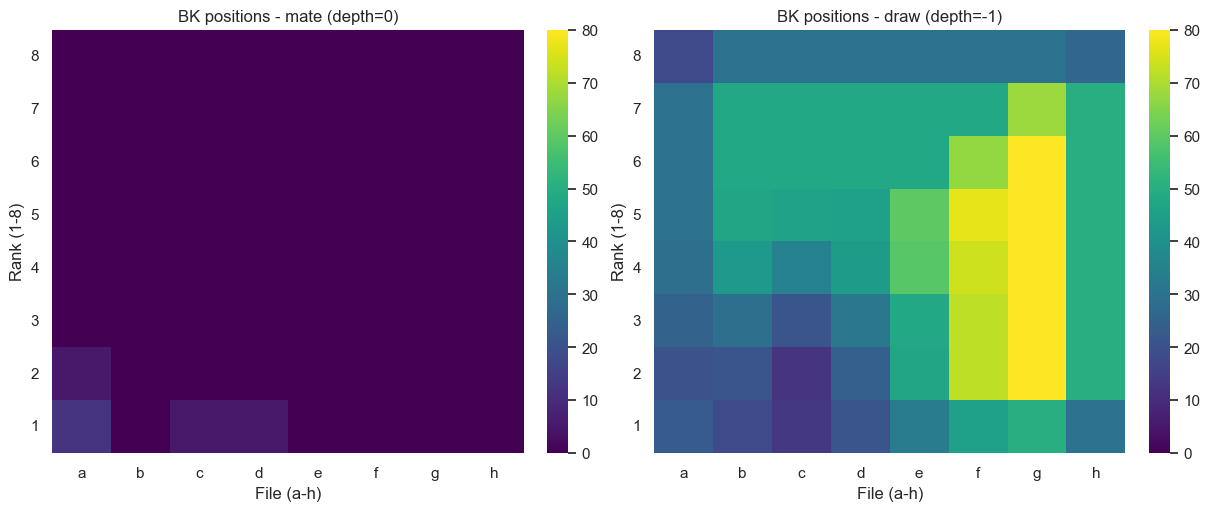

In [9]:

mate = df[df["white_depth_of_win"] == 0]
draw = df[df["white_depth_of_win"] == -1]


def bk_counts(data):
    pivot = (
        data.groupby(["bk_rank", "bk_file"]).size()
        .unstack(fill_value=0)
        .reindex(index=range(1, 9), columns=range(1, 9), fill_value=0)
    )
    return pivot

mate_counts = bk_counts(mate)
draw_counts = bk_counts(draw)
vmax = max(mate_counts.to_numpy().max(), draw_counts.to_numpy().max())

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

sns.heatmap(mate_counts, ax=axes[0], cmap="viridis", vmin=0, vmax=vmax, cbar=True)
axes[0].set_title("BK positions - mate (depth=0)")
axes[0].set_xlabel("File (a-h)")
axes[0].set_ylabel("Rank (1-8)")
axes[0].set_xticklabels(list("abcdefgh"))
axes[0].set_yticklabels(range(1, 9), rotation=0)
axes[0].invert_yaxis()

sns.heatmap(draw_counts, ax=axes[1], cmap="viridis", vmin=0, vmax=vmax, cbar=True)
axes[1].set_title("BK positions - draw (depth=-1)")
axes[1].set_xlabel("File (a-h)")
axes[1].set_ylabel("Rank (1-8)")
axes[1].set_xticklabels(list("abcdefgh"))
axes[1].set_yticklabels(range(1, 9), rotation=0)
axes[1].invert_yaxis()

plt.show()


Komentarz: Na mapie widać, że czarny król jest matowany niemal wyłącznie na krawędzi planszy, z wyraźnym maksimum w narożniku (okolice a1) oraz pojedynczymi przypadkami na sąsiednich polach krawędzi (np. a2, c1–d1). Empirycznie sugeruje to, że pozycje matowe w tej końcówce występują głównie wtedy, gdy BK znajduje się „dociśnięty” do brzegu.

Draw (depth=-1): W remisach rozkład jest znacznie bardziej rozproszony, ale z wyraźnym skupieniem w rejonie prawej strony planszy (szczególnie file g) i na środkowych rangach (około 2–6). Oznacza to, że pozycje remisowe nie są ograniczone wyłącznie do narożników - częściej pojawiają się, gdy BK znajduje się blisko krawędzi, ale niekoniecznie w rogu, oraz w pewnym „pasie” pól.


## P2 – Ktora metryka najlepiej estymuje liczbe ruchow do mata
Porownanie trzech metryk odleglosci WK–BK z wykorzystaniem korelacji Spearmana i wykresow srednich wartosci depth w funkcji dystansu (bez remisow).


Best metric by |rho|: dist_manhattan (rho=0.257)


,spearman_rho,abs_rho
dist_manhattan,0.256605,0.256605
dist_euclid,0.242819,0.242819
dist_chebyshev,0.212660,0.212660


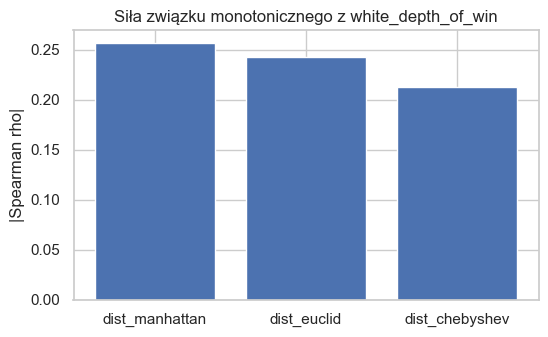

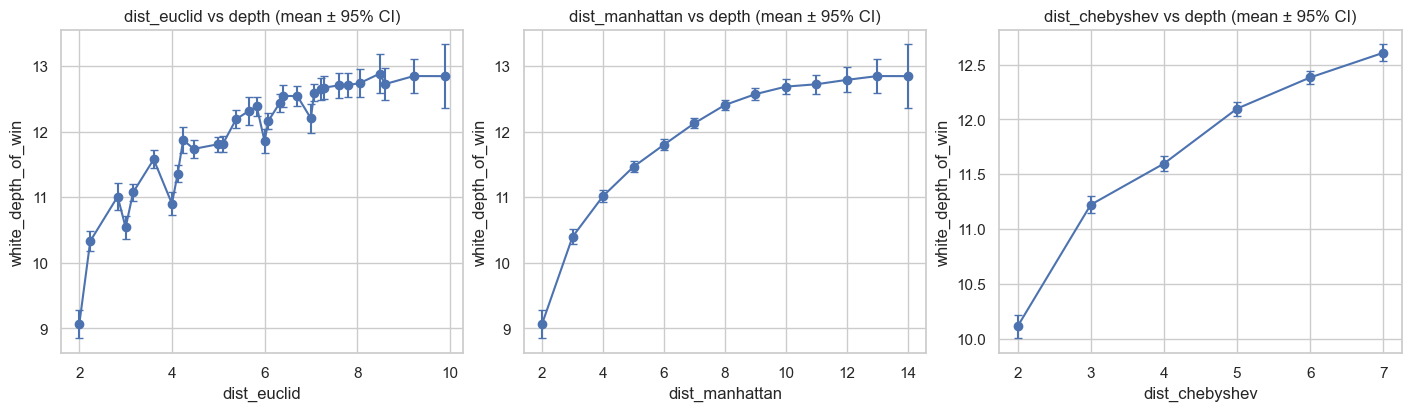

In [13]:
nd = df.loc[df["white_depth_of_win"].ne(-1)].copy()

dist_cols = ["dist_euclid", "dist_manhattan", "dist_chebyshev"]

spearman_tbl = (
    nd[dist_cols + ["white_depth_of_win"]]
    .corr(method="spearman")["white_depth_of_win"]
    .drop("white_depth_of_win")
    .to_frame("spearman_rho")
)
spearman_tbl["abs_rho"] = spearman_tbl["spearman_rho"].abs()
spearman_tbl = spearman_tbl.sort_values("abs_rho", ascending=False)

best_metric = spearman_tbl.index[0]
best_rho = spearman_tbl.iloc[0]["spearman_rho"]

print(f"Best metric by |rho|: {best_metric} (rho={best_rho:.3f})")
display(spearman_tbl)

plt.figure(figsize=(6, 3.5))
plt.bar(spearman_tbl.index, spearman_tbl["abs_rho"])
plt.ylabel("|Spearman rho|")
plt.title("Siła związku monotonicznego z white_depth_of_win")
plt.xticks(rotation=0)
plt.show()

tmp = nd.copy()
tmp["dist_euclid_g"] = tmp["dist_euclid"].round(3)
group_col = {"dist_euclid": "dist_euclid_g", "dist_manhattan": "dist_manhattan", "dist_chebyshev": "dist_chebyshev"}

fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

for ax, col in zip(axes, dist_cols):
    gcol = group_col[col]
    stats = tmp.groupby(gcol)["white_depth_of_win"].agg(["mean", "count", "std"]).reset_index()
    stats["sem"] = stats["std"] / np.sqrt(stats["count"])
    stats["ci95"] = 1.96 * stats["sem"]
    stats["ci95"] = stats["ci95"].fillna(0)

    stats = stats.sort_values(gcol)
    x = stats[gcol].astype(float).values
    y = stats["mean"].values
    yerr = stats["ci95"].values

    ax.errorbar(x, y, yerr=yerr, fmt="-o", capsize=3)
    ax.set_title(f"{col} vs depth (mean ± 95% CI)")
    ax.set_xlabel(col)
    ax.set_ylabel("white_depth_of_win")

plt.show()


Komentarz: Po odrzuceniu remisów (white_depth_of_win != -1) porównałem trzy metryki dystansu WK–BK (euklidesową, Manhattan i Czebyszewa) pod kątem związku z liczbą ruchów do mata. Jako kryterium przyjąłem korelację Spearmana, bo interesuje nas zależność monotoniczna (większy dystans → zwykle większy depth), a depth jest zmienną dyskretną.

Najwyższą wartość |ρ| uzyskał dystans Manhattan (ρ ≈ 0.257), wyprzedzając euklidesowy (≈ 0.243) i Czebyszewa (≈ 0.213). Wykresy średniej white_depth_of_win z 95% CI potwierdzają ten wynik: dla Manhattana trend wzrostowy jest najbardziej konsekwentny. Związek jest jednak umiarkowany, co sugeruje, że sama odległość król–król nie wystarcza do pełnego wyjaśnienia depth (istotne jest też położenie wieży).

## P3 – Czy edge_dist pomaga, i czy pomaga dodatkowo w polaczeniu z dystansem WK–BK
Sprawdzamy uzytecznosc edge_dist w przewidywaniu white_depth_of_win oraz efekt dolaczenia najlepszej metryki z P2.


Delta R2: 0.218
Delta MAE: -0.310


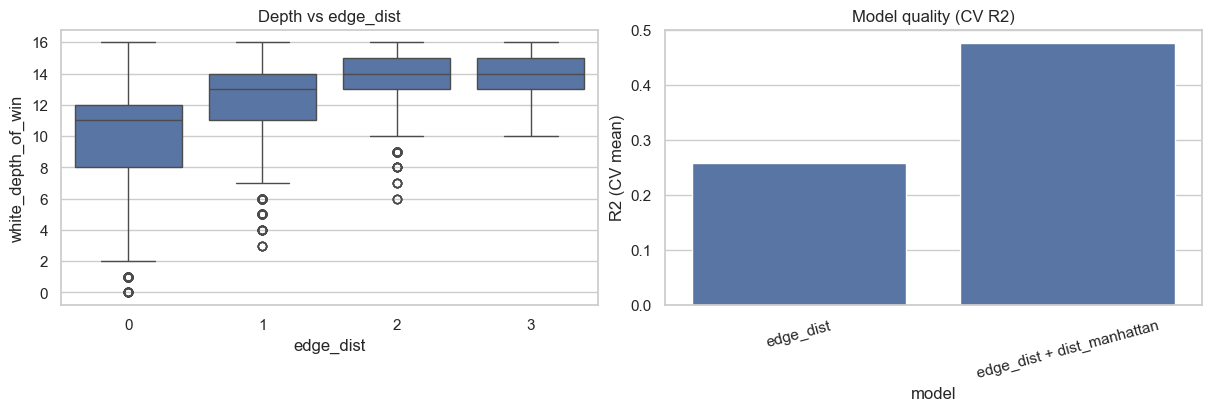

In [14]:

y = nd["white_depth_of_win"].values

X_edge = nd[["edge_dist"]].values
X_edge_best = nd[["edge_dist", best_metric]].values

cv = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()

scoring = {
    "r2": "r2",
    "mae": make_scorer(mean_absolute_error, greater_is_better=False),
}

cv_edge = cross_validate(model, X_edge, y, cv=cv, scoring=scoring)
cv_edge_best = cross_validate(model, X_edge_best, y, cv=cv, scoring=scoring)

results = pd.DataFrame({
    "model": ["edge_dist", f"edge_dist + {best_metric}"],
    "R2_mean": [np.mean(cv_edge["test_r2"]), np.mean(cv_edge_best["test_r2"])],
    "MAE_mean": [-np.mean(cv_edge["test_mae"]), -np.mean(cv_edge_best["test_mae"])],
})

results

r2_delta = results.loc[1, "R2_mean"] - results.loc[0, "R2_mean"]
mae_delta = results.loc[1, "MAE_mean"] - results.loc[0, "MAE_mean"]

print(f"Delta R2: {r2_delta:.3f}")
print(f"Delta MAE: {mae_delta:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

sns.boxplot(data=nd, x="edge_dist", y="white_depth_of_win", ax=axes[0])
axes[0].set_title("Depth vs edge_dist")
axes[0].set_xlabel("edge_dist")
axes[0].set_ylabel("white_depth_of_win")

sns.barplot(data=results, x="model", y="R2_mean", ax=axes[1])
axes[1].set_title("Model quality (CV R2)")
axes[1].set_xlabel("model")
axes[1].set_ylabel("R2 (CV mean)")
axes[1].tick_params(axis="x", rotation=15)

plt.show()



Po odrzuceniu remisów widać, że edge_dist jest użyteczne: boxplot pokazuje rosnącą medianę white_depth_of_win wraz ze wzrostem odległości BK od krawędzi, czyli im dalej czarny król od brzegu, tym przeciętnie więcej ruchów potrzeba do mata. Potwierdza to model liniowy oceniony w 5-fold CV: sam edge_dist daje umiarkowane dopasowanie (CV R² ~ 0.26). Dodanie najlepszego dystansu WK–BK z zadania 2 (u Ciebie dist_manhattan) wyraźnie poprawia wynik (CV R² ~ 0.48, wzrost o ~0.22), więc połączenie obu cech lepiej przewiduje liczbę ruchów do zakończenia gry.

## Wnioski
- Pozycje matowe (depth=0) występują najczęściej, gdy czarny król znajduje się na krawędzi planszy, szczególnie w rejonie narożników. Pozycje remisowe (depth=-1) mają rozkład bardziej rozproszony i nie są ograniczone do samych narożników.

- Dla pozycji wygranych (bez remisów) dystans między królami ma dodatni związek z liczbą ruchów do mata: im dalej WK od BK, tym przeciętnie większy white_depth_of_win. Spośród trzech metryk najlepiej sprawdza się dystans Manhattan (największe |ρ Spearmana|), choć zależność jest umiarkowana.

- Odległość BK od krawędzi (edge_dist) jest informacyjna: im dalej czarny król od brzegu, tym zwykle więcej ruchów potrzeba do zakończenia gry. Połączenie edge_dist z dystansem WK–BK (Manhattan) istotnie poprawia jakość przewidywania (wyraźny wzrost CV R²), więc obie cechy niosą komplementarną informację o trudności pozycji.
